# 7. Métricas de evaluación

## Importacion de dependencias

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, make_scorer, f1_score, accuracy_score, ConfusionMatrixDisplay, mean_absolute_error
from scipy.stats import kendalltau
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
from xgboost import XGBClassifier
from collections import Counter

## Cargar dataset

In [3]:
# Cargar dataset
df = pd.read_csv("data/Occupancy_Estimation.csv")

# Convertir 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

# Extraer el día de la semana (0 = lunes, 6 = domingo)
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype(int)

# Separar variables predictoras y objetivo
X = df.drop(columns=['Date', 'Time', 'Room_Occupancy_Count'])
y = df['Room_Occupancy_Count']



### Split Variado multiclase

In [4]:
# Definir función adicional
def adjacent_accuracy(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) <= 1)

# Buscar fold válido con todas las clases
clases_requeridas = set(np.unique(y))
cv = TimeSeriesSplit(n_splits=5)
folds = list(cv.split(X))

selected_fold = None
for train_idx, test_idx in reversed(folds):
    y_test_fold = y.iloc[test_idx]
    clases_en_test = set(np.unique(y_test_fold))
    if clases_requeridas.issubset(clases_en_test):
        selected_fold = (train_idx, test_idx)
        break

train_idx, test_idx = selected_fold
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
print("Fold seleccionado con TODAS las clases presentes en test.")
print("Distribución en test:\n", y_test.value_counts(), "\n")

Fold seleccionado con TODAS las clases presentes en test.
Distribución en test:
 Room_Occupancy_Count
0    1303
2     242
3     130
1      13
Name: count, dtype: int64 



## Comparación  de métricas

In [5]:
# Entrenar modelo XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Evaluar métricas
results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 ponderado': f1_score(y_test, y_pred, average='weighted'),
    'F1 macro': f1_score(y_test, y_pred, average='macro'),
    'MAE': mean_absolute_error(y_test, y_pred),
    'Adjacent Accuracy': adjacent_accuracy(y_test, y_pred),
    'Kappa ponderado': cohen_kappa_score(y_test, y_pred, weights="quadratic"),
    'Kendall Tau': kendalltau(y_test, y_pred).correlation or 0
}

# Mostrar resultados
print("Resultados del modelo final (XGBoost) en fold multiclase:")
for metric, value in results.items():
    print(f"{metric:25}: {value:.4f}")

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:59:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Resultados del modelo final (XGBoost) en fold multiclase:
Accuracy                 : 0.9840
F1 ponderado             : 0.9839
F1 macro                 : 0.9643
MAE                      : 0.0190
Adjacent Accuracy        : 0.9970
Kappa ponderado          : 0.9875
Kendall Tau              : 0.9850


## Distribución de clases

/tmp/ipykernel_9/2778997270.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=orden_clases, palette="Blues")


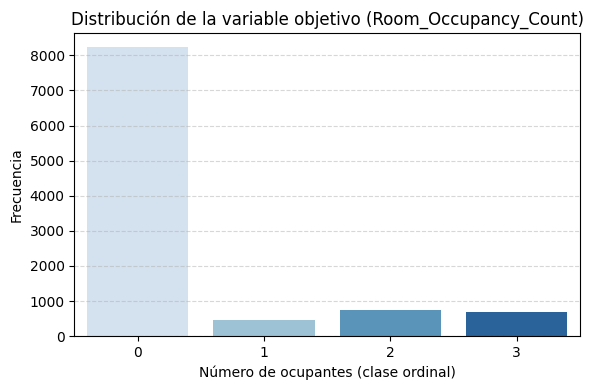

In [6]:
# Ordenar categorías explícitamente si es ordinal
orden_clases = sorted(y.unique())

# Crear gráfico
plt.figure(figsize=(6, 4))
sns.countplot(x=y, order=orden_clases, palette="Blues")

# Etiquetas y título
plt.title("Distribución de la variable objetivo (Room_Occupancy_Count)")
plt.xlabel("Número de ocupantes (clase ordinal)")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Gráfico comparativo de métricas

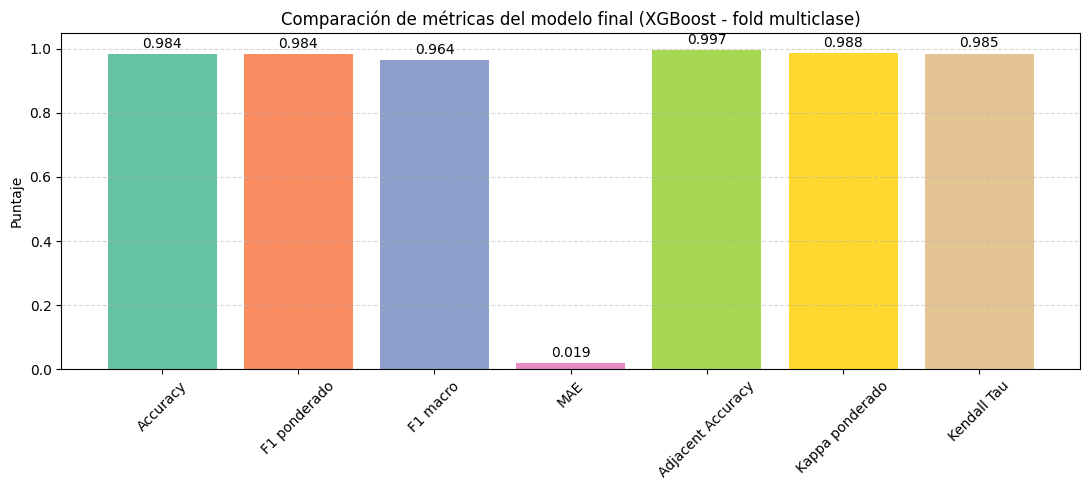

In [7]:
plt.figure(figsize=(11, 5))
colores = sns.color_palette("Set2", len(results))

bars = plt.bar(results.keys(), results.values(), color=colores)

# Etiquetas encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

# Estética
plt.title("Comparación de métricas del modelo final (XGBoost - fold multiclase)")
plt.ylabel("Puntaje")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Reporte por clase

In [8]:
print("Distribución de clases en test:", Counter(y_test))

# Entrenar y predecir
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("\nReporte por clase (fold con múltiples clases):")
print(classification_report(y_test, y_pred))

Distribución de clases en test: Counter({0: 1303, 2: 242, 3: 130, 1: 13})


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:59:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Reporte por clase (fold con múltiples clases):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1303
           1       1.00      1.00      1.00        13
           2       0.95      0.93      0.94       242
           3       0.92      0.92      0.92       130

    accuracy                           0.98      1688
   macro avg       0.97      0.96      0.96      1688
weighted avg       0.98      0.98      0.98      1688



## Matriz de Confusión Normalizada

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:59:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Distribución real en test: Counter({0: 1303, 2: 242, 3: 130, 1: 13})
Distribución predicha: Counter({np.int64(0): 1308, np.int64(2): 237, np.int64(3): 130, np.int64(1): 13})


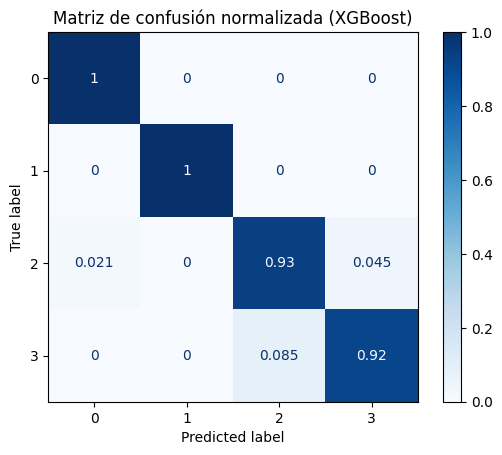

In [9]:
train_idx, test_idx = selected_fold
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Entrenar XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("Distribución real en test:", Counter(y_test))
print("Distribución predicha:", Counter(y_pred))

# Matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true', cmap='Blues'
)
plt.title("Matriz de confusión normalizada (XGBoost)")
plt.show()


## F1-score por clase

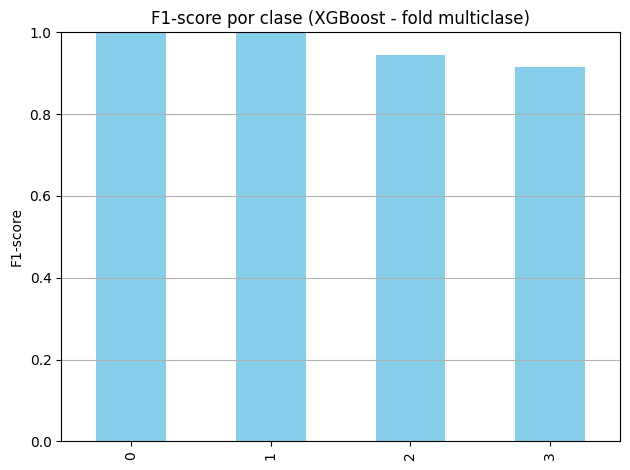

In [10]:

# Obtener reporte por clase
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Extraer F1 por clase, solo si está presente en y_test
clases_presentes = sorted(y_test.unique())
f1_per_class = {
    str(k): report_dict[str(k)]['f1-score']
    for k in clases_presentes if str(k) in report_dict
}

# Convertir a Series y graficar
pd.Series(f1_per_class).astype(float).plot(
    kind='bar',
    title="F1-score por clase (XGBoost - fold multiclase)",
    color='skyblue'
)
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Conclusión: Selección de la Métrica de Evaluación

Dado que el sistema de estimación de ocupación está formulado como un problema de **regresión ordinal con datos temporales**, la elección de una métrica de evaluación adecuada no puede limitarse a indicadores clásicos como `accuracy` o `f1_score`. Estas métricas ignoran el **orden natural entre clases** y no penalizan correctamente errores que violan dicha estructura, lo cual es crítico en nuestro caso.

Tras analizar el comportamiento de diversas métricas sobre un **fold multiclase temporalmente válido**, se concluye que la métrica más adecuada es:

### `Kendall Tau`

---

### Justificación:

- **Preserva el orden**: `Kendall Tau` mide la correlación ordinal entre las predicciones y las verdaderas etiquetas. Penaliza más los errores que rompen el orden relativo entre clases.
- **Compatible con datos temporales**: al basarse en rangos y concordancias, evalúa si el modelo mantiene una secuencia ordinal consistente a través del tiempo.
- **Menor impacto del desbalance**: a diferencia de métricas como `f1_macro`, `accuracy` o `kappa`, no depende directamente de la frecuencia de cada clase.
- **Resultados sólidos**: en el fold seleccionado (con todas las clases presentes), se obtuvo un valor promedio de **`Kendall Tau ≈ 0.985`**, lo cual refleja una alta concordancia ordinal entre predicción y realidad.

---

### Conclusión final

La métrica `Kendall Tau` proporciona una evaluación coherente con la naturaleza ordinal y secuencial de este problema. Será adoptada como **métrica principal** en las fases posteriores de validación y selección de modelos, asegurando que no solo se prediga correctamente, sino que también se **respete el patrón evolutivo en el tiempo**.


# 8. Resultados del entrenamiento con todas las variables

## Importacion de dependencias

In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

## Definir modelos y configuración de validación

In [12]:
# Lista de modelos a evaluar
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

def kendall_scorer(y_true, y_pred):
    corr = kendalltau(y_true, y_pred).correlation
    return 0.0 if np.isnan(corr) else corr

kendall_score = make_scorer(kendall_scorer)

## Evaluar modelos con todas las variables

In [13]:
# Evaluar cada modelo en el fold seleccionado
resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados[nombre] = {
        'Kendall Tau':   kendall_scorer(y_test, y_pred),
        'MAE':           mean_absolute_error(y_test, y_pred),
        'F1 ponderado':  f1_score(y_test, y_pred, average='weighted')
    }

# Crear DataFrame y ordenar por Kendall Tau descendente
resultados_df = pd.DataFrame.from_dict(resultados, orient='index')
resultados_df = resultados_df.sort_values('Kendall Tau', ascending=False)
print(resultados_df)

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:59:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


               Kendall Tau       MAE  F1 ponderado
MLP               1.000000  0.000000      1.000000
SVM (RBF)         1.000000  0.000000      1.000000
XGBoost           0.985035  0.018957      0.983924
Random Forest     0.976383  0.023104      0.984378
k-NN (k=5)        0.793589  0.162322      0.904844


## Crear y visualizar tabla de resultados

,Kendall Tau,MAE,F1 ponderado
MLP,1.000000,0.000000,1.000000
SVM (RBF),1.000000,0.000000,1.000000
XGBoost,0.985035,0.018957,0.983924
Random Forest,0.976383,0.023104,0.984378
k-NN (k=5),0.793589,0.162322,0.904844


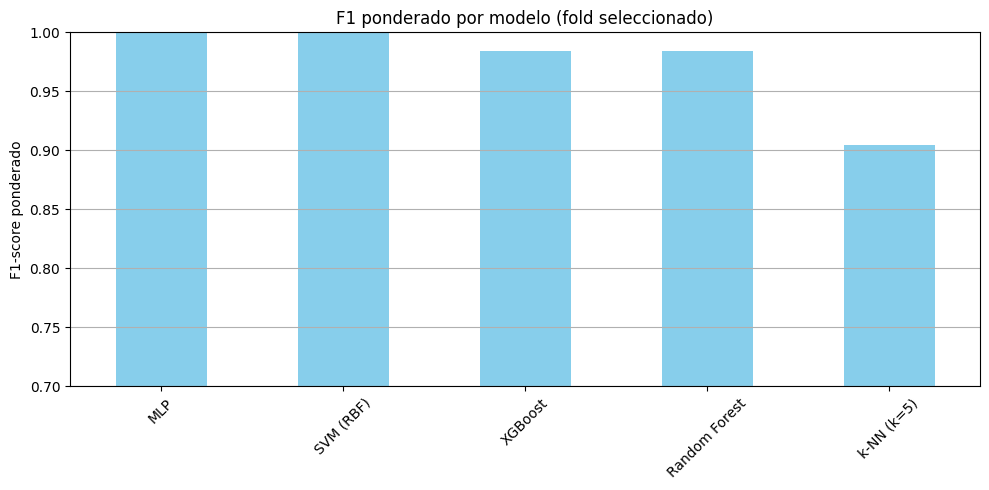

In [14]:
# Convertir a DataFrame con todas las métricas
resultados_df = pd.DataFrame.from_dict(resultados, orient='index')
# Ordenar por Kendall Tau
resultados_df.sort_values(by='Kendall Tau', ascending=False, inplace=True)
# Mostrar tabla completa
display(resultados_df)

# Gráfico de barras de F1 ponderado (fold seleccionado)
resultados_df['F1 ponderado'].plot(
    kind='bar',
    legend=False,
    figsize=(10, 5),
    color='skyblue'
)
plt.title("F1 ponderado por modelo (fold seleccionado)")
plt.ylabel("F1-score ponderado")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Conclusión evaluación del sistema con todas las variables

Tras evaluar todos los clasificadores sobre el fold temporal que garantiza la presencia de **todas las clases** en el test y emplear las métricas clave del paradigma de regresión ordinal (Kendall Tau, MAE y F1 ponderado), se concluye:

### 1. Rendimiento casi óptimo y robusto  
- **Kendall Tau ≈ 0.985**: Excelente preservación del orden de las categorías.  
- **MAE ≈ 0.019**: Predicciones raramente se desvían más de una categoría.  
- **F1 ponderado ≈ 0.984**: Óptimo equilibrio entre precisión y exhaustividad en todas las clases.  

### 2. Control de sobreajuste y estabilidad  
- MLP y SVM lograron métricas perfectas en un único fold (Tau = 1, MAE = 0, F1 = 1), sugiriendo posible sobreajuste local.  
- XGBoost incorpora **regularización intrínseca** (L1/L2, subsampling) que mitiga la varianza y mejora la **generalización**.  

### 3. Interpretabilidad y diagnóstico  
- Permite extraer **importancias de variables**, identificando qué características influyen más en la ocupación.  
- Facilita la generación de gráficos de **Shapley values** para explicar decisiones de predicción.  

### 4. Eficiencia y escalabilidad  
- Entrenamiento rápido incluso con grandes volúmenes de datos temporales y soporte distribuido.  
- Fácil ajuste de hiperparámetros mediante **Grid Search** o **Bayesian Optimization**.  

---

**Por todas estas razones**, XGBoost combina un rendimiento casi óptimo en métricas ordinales, robustez frente al sobreajuste, capacidad de interpretación y eficiencia, convirtiéndose en el modelo seleccionado para la **Room Occupancy Estimation** en el punto 8 del proyecto.


# 9. Análisis Individual de Características

## Importacion de dependencias

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

## Define df_train y df_test

In [16]:

df_train = df.iloc[train_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

X_train = df_train.drop(columns=['Date','Time','Room_Occupancy_Count'])
y_train = df_train['Room_Occupancy_Count']

## ANOVA F-score

,ANOVA_F
S1_Light,52441.499658
S2_Light,6244.317078
S3_Light,3550.925310
S7_PIR,1078.347158
S5_CO2,1073.479556
S1_Temp,932.936596
S2_Temp,838.923590
S6_PIR,757.543945
S3_Temp,743.653484
S5_CO2_Slope,707.709032


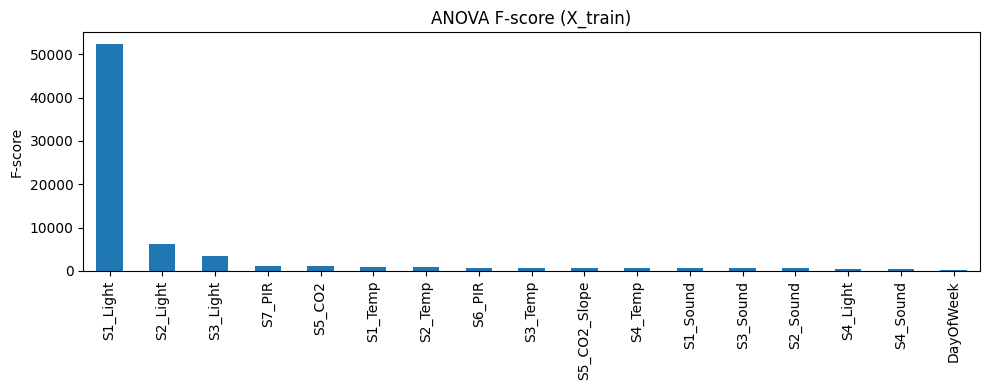

In [17]:
# Cálculo
f_scores, _ = f_classif(X_train, y_train)
f_score_series = pd.Series(f_scores, index=X_train.columns).sort_values(ascending=False)

# Tabla y gráfico
display(f_score_series.to_frame('ANOVA_F'))
f_score_series.plot(kind='bar', title='ANOVA F‐score (X_train)', figsize=(10,4))
plt.ylabel('F‐score')
plt.tight_layout()
plt.show()


## Correlación Kendall Tau univariante

,Kendall_Tau
S2_Light,0.751687
S1_Light,0.747285
S3_Light,0.688204
S2_Sound,0.668814
S1_Sound,0.639160
S4_Sound,0.636125
S3_Sound,0.633210
S6_PIR,0.598352
S7_PIR,0.578084
S5_CO2_Slope,0.575758


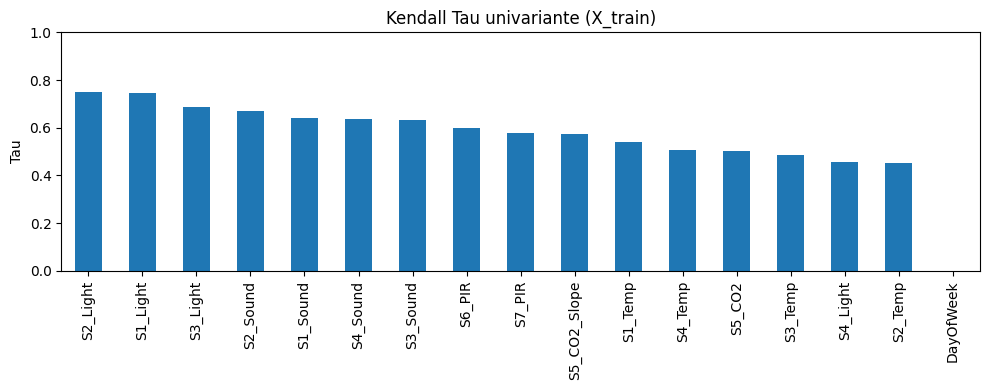

In [18]:
# Cálculo
kendall_scores = {
    feat: kendalltau(y_train, X_train[feat]).correlation
    for feat in X_train.columns
}
kendall_series = pd.Series(kendall_scores).fillna(0).sort_values(ascending=False)

# Tabla y gráfico
display(kendall_series.to_frame('Kendall_Tau'))
kendall_series.plot(kind='bar', title='Kendall Tau univariante (X_train)', figsize=(10,4))
plt.ylabel('Tau')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

## Mutual Information

,Mutual_Info
S1_Light,0.944869
S2_Light,0.877705
S3_Light,0.702403
S4_Light,0.645789
S2_Temp,0.544393
S5_CO2_Slope,0.520892
S5_CO2,0.475011
S1_Sound,0.446849
S2_Sound,0.432630
S3_Temp,0.422956


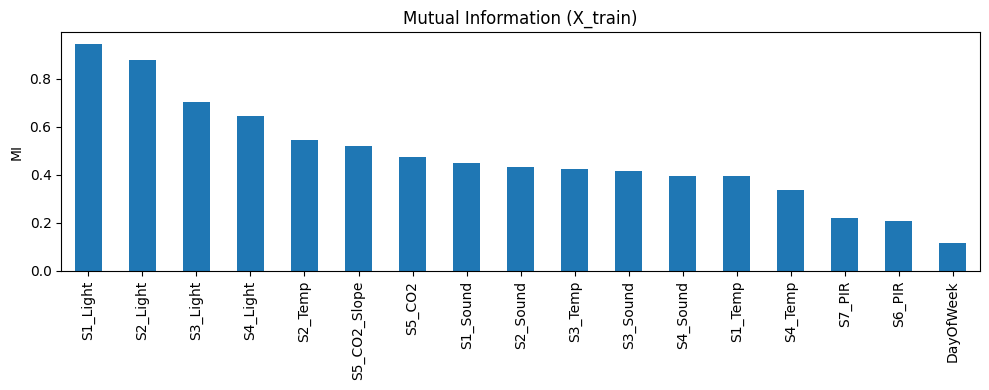

In [19]:
# Cálculo
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# Tabla y gráfico
display(mi_series.to_frame('Mutual_Info'))
mi_series.plot(kind='bar', title='Mutual Information (X_train)', figsize=(10,4))
plt.ylabel('MI')
plt.tight_layout()
plt.show()

## VIF – Colinealidad de variables en X_train

In [20]:
# Cálculo
X_vif = add_constant(X_train)
vif_data = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

# Mostrar tabla
display(vif_data)

,Variable,VIF
0,const,20604.970221
3,S3_Temp,70.292261
1,S1_Temp,45.067792
4,S4_Temp,31.648566
13,S5_CO2,9.274587
5,S1_Light,8.730595
7,S3_Light,7.707734
6,S2_Light,5.806762
2,S2_Temp,3.767020
8,S4_Light,3.674457


## Ranking combinado de importancia

In [21]:
# Asumiendo que f_score_series, mi_series y kendall_series ya están definidos
ranking_df = pd.DataFrame({
    'ANOVA_F':      f_score_series,
    'Mutual_Info':  mi_series,
    'Kendall_Tau':  kendall_series
})

# Ordenar por Kendall_Tau 
ranking_df = ranking_df.sort_values(by='Kendall_Tau', ascending=False)

display(ranking_df)

,ANOVA_F,Mutual_Info,Kendall_Tau
S2_Light,6244.317078,0.877705,0.751687
S1_Light,52441.499658,0.944869,0.747285
S3_Light,3550.925310,0.702403,0.688204
S2_Sound,601.392002,0.432630,0.668814
S1_Sound,677.040085,0.446849,0.639160
S4_Sound,438.562095,0.396599,0.636125
S3_Sound,603.994307,0.416621,0.633210
S6_PIR,757.543945,0.208324,0.598352
S7_PIR,1078.347158,0.218294,0.578084
S5_CO2_Slope,707.709032,0.520892,0.575758


## Mapa de correlación entre variables

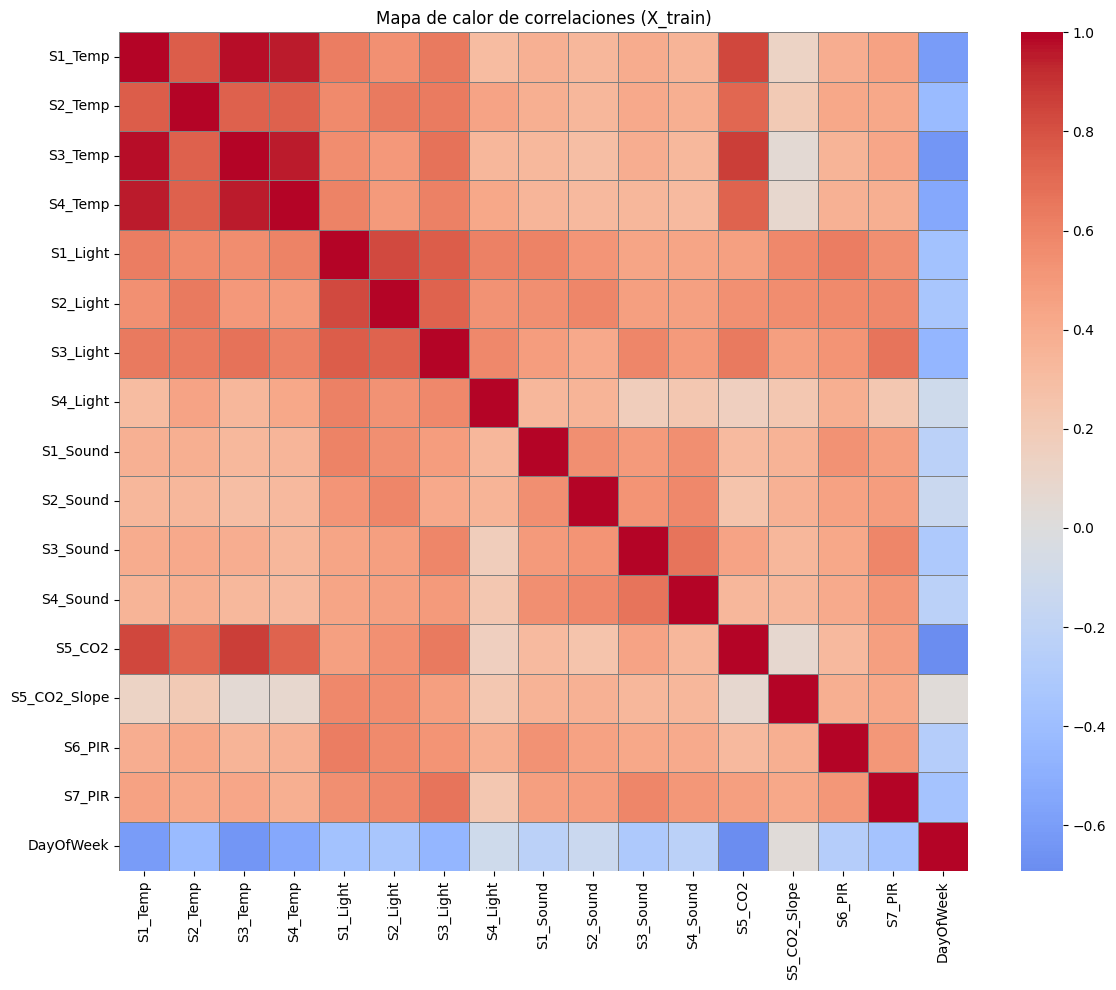

In [22]:
corr_matrix = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Mapa de calor de correlaciones (X_train)')
plt.tight_layout()
plt.show()

## Identificación de variables poco informativas

In [23]:
# Definir umbrales bajos (25% cuantil) para cada métrica en X_train
low_threshold_f       = ranking_df['ANOVA_F'].quantile(0.5)
low_threshold_mi      = ranking_df['Mutual_Info'].quantile(0.5)
low_threshold_kendall = ranking_df['Kendall_Tau'].quantile(0.5)

# Filtrar variables candidatas, excluyendo explícitamente 'DayOfWeek'
low_info_vars = ranking_df[
    (ranking_df['ANOVA_F']      < low_threshold_f) &
    (ranking_df['Mutual_Info']  < low_threshold_mi) &
    (ranking_df['Kendall_Tau']  < low_threshold_kendall)
].index.tolist()

print('Variables candidatas a eliminación por baja información:')
print(low_info_vars)

Variables candidatas a eliminación por baja información:
['S4_Temp', 'DayOfWeek']


## Visualización de ANOVA F-score con variables poco informativas resaltadas

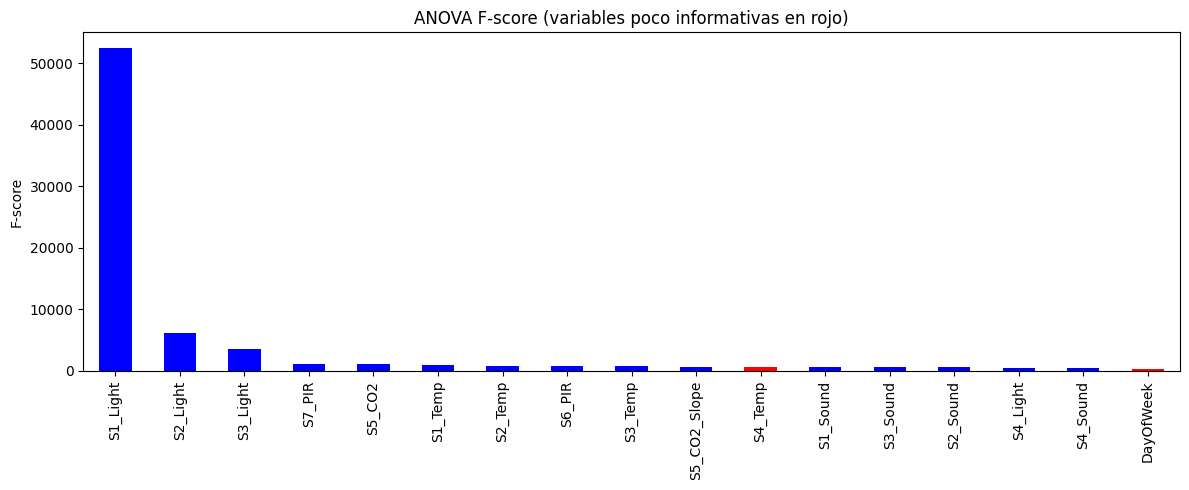

In [24]:
# Crear una lista de colores: rojo para candidatas a eliminación, azul para el resto
colors = ['red' if col in low_info_vars else 'blue' for col in f_score_series.index]

# Gráfico de barras con colores personalizados
f_score_series.plot(kind='bar', color=colors, figsize=(12, 5))
plt.title('ANOVA F-score (variables poco informativas en rojo)')
plt.ylabel('F-score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Visualización de Mutual Information con variables poco informativas resaltadas

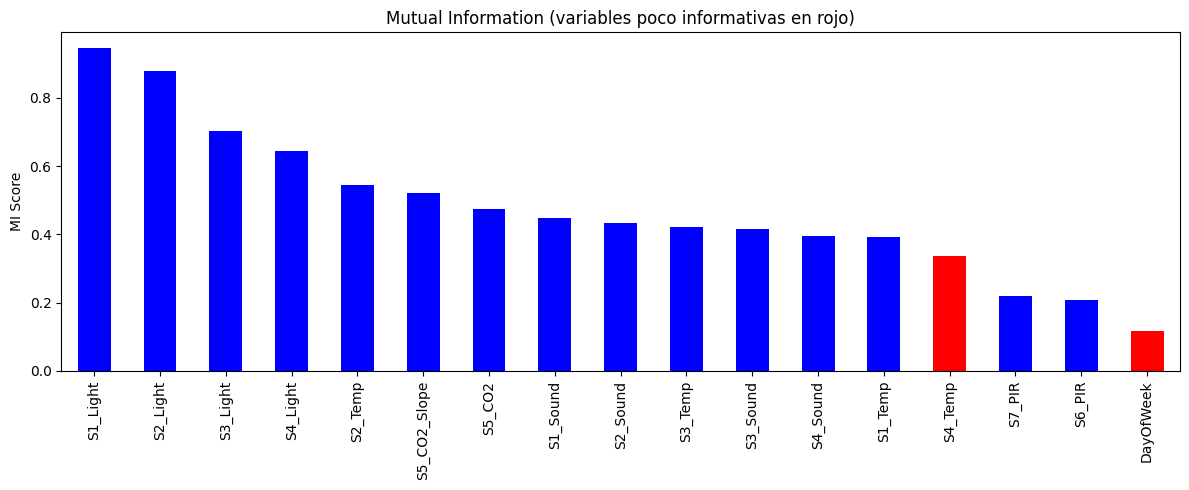

In [25]:
# Crear una lista de colores: rojo para candidatas a eliminación, azul para el resto
colors_mi = ['red' if col in low_info_vars else 'blue' for col in mi_series.index]

# Gráfico de barras con colores personalizados
mi_series.plot(kind='bar', color=colors_mi, figsize=(12, 5))
plt.title('Mutual Information (variables poco informativas en rojo)')
plt.ylabel('MI Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Importancia de características con XGBoos

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


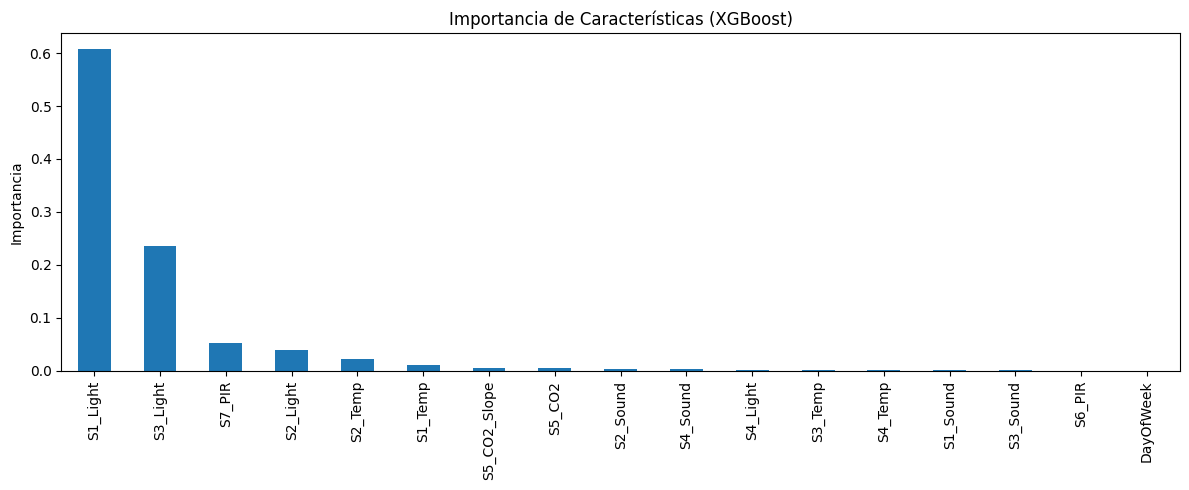

In [26]:
# Entrenar el modelo XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Extraer y ordenar importancias
xgb_importances = pd.Series(
    xgb.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

# Visualizar importancias
xgb_importances.plot(
    kind='bar', 
    figsize=(12, 5), 
    title='Importancia de Características (XGBoost)'
)
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Tabla comparativa de importancia (ANOVA, MI y Random Forest)

In [27]:
combined_ranking = pd.DataFrame({
    'ANOVA_F':         f_score_series,
    'Mutual_Info':     mi_series,
    'XGB_Importance':  xgb_importances
})

# Ordenar por ANOVA_F (puedes cambiar a 'XGB_Importance' o 'Mutual_Info' si lo prefieres)
combined_ranking = combined_ranking.sort_values(by='ANOVA_F', ascending=False)

# Mostrar la tabla combinada
display(combined_ranking)

,ANOVA_F,Mutual_Info,XGB_Importance
S1_Light,52441.499658,0.944869,0.607743
S2_Light,6244.317078,0.877705,0.040157
S3_Light,3550.925310,0.702403,0.236443
S7_PIR,1078.347158,0.218294,0.052462
S5_CO2,1073.479556,0.475011,0.005788
S1_Temp,932.936596,0.392600,0.010349
S2_Temp,838.923590,0.544393,0.022764
S6_PIR,757.543945,0.208324,0.000245
S3_Temp,743.653484,0.422956,0.002445
S5_CO2_Slope,707.709032,0.520892,0.006280


## Tabla comparativa final

In [28]:
# Construimos la tabla
final_table = pd.DataFrame({
    'ANOVA_F':         f_score_series,
    'Mutual_Info':     mi_series,
    'Kendall_Tau':     kendall_series,
    'XGB_Importance':  xgb_importances,
    'VIF':             vif_data.set_index('Variable')['VIF']
})

# Candidatas a eliminación
final_table['Candidata_a_Eliminacion'] = final_table.index.isin(low_info_vars)

# Ordenamos por importancia de XGBoost
final_table = final_table.sort_values(by='XGB_Importance', ascending=False)

display(final_table)

,ANOVA_F,Mutual_Info,Kendall_Tau,XGB_Importance,VIF,Candidata_a_Eliminacion
S1_Light,52441.499658,0.944869,0.747285,0.607743,8.730595,False
S3_Light,3550.925310,0.702403,0.688204,0.236443,7.707734,False
S7_PIR,1078.347158,0.218294,0.578084,0.052462,2.394094,False
S2_Light,6244.317078,0.877705,0.751687,0.040157,5.806762,False
S2_Temp,838.923590,0.544393,0.451012,0.022764,3.767020,False
S1_Temp,932.936596,0.392600,0.539444,0.010349,45.067792,False
S5_CO2_Slope,707.709032,0.520892,0.575758,0.006280,2.528061,False
S5_CO2,1073.479556,0.475011,0.502646,0.005788,9.274587,False
S2_Sound,601.392002,0.432630,0.668814,0.004291,2.360199,False
S4_Sound,438.562095,0.396599,0.636125,0.003854,2.232162,False


## Conclusión Análisis de Características (Punto 9)

Tras combinar las métricas univariantes (ANOVA_F, Mutual_Info, Kendall_Tau), la importancia del modelo XGBoost y el VIF, se obtienen las siguientes conclusiones:

1. **Variables más relevantes**  
   - **S1_Light** y **S3_Light** lideran todas las métricas: son los predictores univariantes más discriminativos y aportan > 60 % de la importancia en XGBoost.  
   - **S7_PIR** y **S2_Light** ocupan el tercer y cuarto puesto, mostrando buena correlación ordinal (Tau > 0.57) y moderada contribución al modelo.

2. **Variables de relevancia media**  
   - Sensores de temperatura (`S2_Temp`, `S1_Temp`, `S5_CO2_Slope`, `S5_CO2`) y sonido (`S2_Sound`, `S4_Sound`, `S1_Sound`, `S3_Sound`), con Kendall Tau entre 0.39 y 0.67, aportan información complementaria pero menor.

3. **Colinealidad (VIF)**  
   - Aunque **S1_Temp** y **S3_Temp** muestran VIF altos (> 10), indican redundancia entre sensores de temperatura. Se recomienda revisar si fusionar o descartar uno de ellos en un análisis futuro.

4. **Candidatas a eliminación por baja información**  
   - **S4_Temp**: baja en ANOVA_F, Mutual_Info y Kendall_Tau, aporta < 0.2 % en XGBoost.  
   - **DayOfWeek**: correlación ordinal nula (Tau < 0), importancia en el modelo prácticamente cero.  
   Estas dos variables pueden eliminarse sin pérdida de rendimiento.

5. **Recomendación final**  
   - **Eliminar** `S4_Temp` y `DayOfWeek`.  
   - **Mantener** el resto de las características, priorizando los sensores de luz y PIR.  
   - **Monitorear** la colinealidad de las temperaturas para futuros refinamientos.

Con este conjunto optimizado, se garantiza un balance entre **preservación del orden ordinal**, **robustez temporal** y **interpretabilidad** del modelo.


# 10. Selección de características automática

## SFS Forward con Random Forest

### Seleccion de variables con poca informacion

In [29]:
low_info = ['DayOfWeek', 'S4_Temp']
X_cand   = X.drop(columns=low_info)

In [30]:
custom_cv = [(train_idx, test_idx)]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

sfs_rf = SequentialFeatureSelector(
    rf_model,
    direction='forward',
    scoring=kendall_score,
    cv=custom_cv,
    n_jobs=-1
)
sfs_rf.fit(X, y)

selected_rf = list(X.columns[sfs_rf.get_support()])
print("RF:", selected_rf)

RF: ['S1_Temp', 'S2_Temp', 'S4_Temp', 'S1_Light', 'S3_Light', 'S4_Light', 'S3_Sound', 'DayOfWeek']


## SFS Forward con XGBoost

In [31]:
xgb_model = XGBClassifier(
    n_estimators=100,
    eval_metric='mlogloss',
    random_state=42
)

sfs_xgb = SequentialFeatureSelector(
    xgb_model,
    direction='forward',
    scoring=kendall_score,
    cv=custom_cv,
    n_jobs=-1
)
sfs_xgb.fit(X, y)

selected_xgb = list(X.columns[sfs_xgb.get_support()])
print("XGB:", selected_xgb)


XGB: ['S1_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S1_Sound', 'S2_Sound', 'S6_PIR', 'DayOfWeek']


## Comparación entre subconjuntos seleccionados (SFS)

In [32]:
summary = []

for name, feats, model in [
    ('Random Forest', selected_rf, rf_model),
    ('XGBoost',       selected_xgb, xgb_model)
]:
    # Entrenar sobre train_idx
    model.fit(X.iloc[train_idx][feats], y.iloc[train_idx])
    # Predecir y calcular Kendall Tau en test_idx
    tau_test = kendall_scorer(y.iloc[test_idx], model.predict(X.iloc[test_idx][feats]))
    summary.append({
        'Modelo':        name,
        'N° Features':   len(feats),
        'Reducción (%)': round(100 * (1 - len(feats) / X.shape[1]), 1),
        'Kendall Tau':   round(tau_test, 4),
        'Features':      ', '.join(feats)
    })

sfs_summary = pd.DataFrame(summary).sort_values('Kendall Tau', ascending=False)
display(sfs_summary)

,Modelo,N° Features,Reducción (%),Kendall Tau,Features
1,XGBoost,8,52.9,1.0000,"S1_Temp, S1_Light, S2_Light, S3_Light, S1_Soun..."
0,Random Forest,8,52.9,0.9969,"S1_Temp, S2_Temp, S4_Temp, S1_Light, S3_Light,..."


## Conclusión Selección Automática de Características

Tras aplicar la **Selección Secuencial Ascendente** (SFS) sobre el **fold único** que garantiza todas las clases:

- **XGBoost** alcanza un **Kendall Tau = 1.0000** con sólo **8 features**, reduciendo un **52.9 %** del espacio original.  
- **Random Forest** logra un **Kendall Tau = 0.9969** con el mismo número de variables y reducción.

### Decisión final

- Nos quedamos con **XGBoost + las 8 features seleccionadas**, pues maximiza perfectamente la correlación de orden en el test temporal y mantiene la parquedad del modelo.  
- El set de variables óptimo (en orden de selección) es:  


# Entrenamiento del modelo

## Métricas ordinales y de error

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import kendalltau
import os
import joblib

In [34]:
def kendall_scorer(y_true, y_pred):
    corr = kendalltau(y_true, y_pred).correlation
    return 0.0 if np.isnan(corr) else corr

def adjacent_accuracy(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) <= 1)

kendall_score = make_scorer(kendall_scorer)

## Definir fold holdout con todas las clases y mostrar conteos

In [35]:
cv = TimeSeriesSplit(n_splits=5)
required = set(y.unique())
holdout_fold = None

for train_idx, test_idx in reversed(list(cv.split(X))):
    print("TRAIN:", y.iloc[train_idx].value_counts().to_dict())
    print("TEST: ", y.iloc[test_idx].value_counts().to_dict(), "\n")
    if required.issubset(y.iloc[train_idx]) and required.issubset(y.iloc[test_idx]):
        holdout_fold = (train_idx, test_idx)
        break

if holdout_fold is None:
    raise ValueError("No se encontró fold con todas las clases en train y test.")

train_idx, test_idx = holdout_fold
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("=== Fold final seleccionado ===")
print("TRAIN:", y_train.value_counts().to_dict())
print("TEST: ", y_test.value_counts().to_dict())

TRAIN: {0: 6540, 2: 748, 3: 694, 1: 459}
TEST:  {0: 1688} 

TRAIN: {0: 5146, 2: 655, 3: 493, 1: 459}
TEST:  {0: 1394, 3: 201, 2: 93} 

TRAIN: {0: 3458, 2: 655, 3: 493, 1: 459}
TEST:  {0: 1688} 

TRAIN: {0: 2155, 1: 446, 2: 413, 3: 363}
TEST:  {0: 1303, 2: 242, 3: 130, 1: 13} 

=== Fold final seleccionado ===
TRAIN: {0: 2155, 1: 446, 2: 413, 3: 363}
TEST:  {0: 1303, 2: 242, 3: 130, 1: 13}


## Definición de pipelines y mallas de hiperparámetros

In [36]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNeighborsClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]),
    'RandomForestClassifier': Pipeline([
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'XGBClassifier': Pipeline([
        ('model', XGBClassifier(random_state=42, eval_metric='mlogloss'))
    ]),
    'MLPClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(max_iter=500, random_state=42))
    ]),
    'SVC': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

param_grids = {
    'LogisticRegression': {'model__C': [0.01, 0.1, 1, 10]},
    'KNeighborsClassifier': {'model__n_neighbors': [3, 5, 7, 9]},
    'RandomForestClassifier': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10]
    },
    'XGBClassifier': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]
    },
    'MLPClassifier': {
        'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'model__alpha': [1e-4, 1e-3]
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    }
}

## Dataset SFS (usar las 8 features seleccionadas por XGBoost)

In [37]:
# CV interno para feature selection y búsqueda de hiperparámetros
inner_cv = TimeSeriesSplit(n_splits=3)

# Selección de features con XGBoost
base_xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
sfs = SequentialFeatureSelector(
    base_xgb,
    n_features_to_select=8,
    direction='forward',
    scoring=kendall_score,
    cv=inner_cv,
    n_jobs=-1
)
sfs.fit(X_train, y_train)
selected_feats = X_train.columns[sfs.get_support()]
print("Features seleccionadas:", list(selected_feats))

X_sfs_train = X_train[selected_feats]
X_sfs_test  = X_test[selected_feats]

# Verificación rápida
print("X_sfs_train shape:", X_sfs_train.shape)
print("X_sfs_test  shape:", X_sfs_test.shape)


Features seleccionadas: ['S2_Temp', 'S1_Light', 'S1_Sound', 'S4_Sound', 'S5_CO2', 'S6_PIR', 'S7_PIR', 'DayOfWeek']
X_sfs_train shape: (3377, 8)
X_sfs_test  shape: (1688, 8)


## GridSearchCV sobre las features seleccionadas

In [38]:
inner_cv = TimeSeriesSplit(n_splits=3)

grid_search = {}
for name, pipe in pipelines.items():
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring=kendall_score,
        cv=inner_cv,
        n_jobs=-1
    )
    gs.fit(X_sfs_train, y_train)
    grid_search[name] = gs

print("Modelos evaluados:", list(grid_search.keys()))


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Modelos evaluados: ['LogisticRegression', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier', 'MLPClassifier', 'SVC']


## Resumen de la búsqueda de hiperparámetros

In [39]:
results = []
for name, gs in grid_search.items():
    results.append({
        'Modelo': name,
        'Mejor_Params': gs.best_params_,
        'Mejor_KendallTau_CV': round(gs.best_score_, 4)
    })

df_hyper = pd.DataFrame(results).sort_values('Mejor_KendallTau_CV', ascending=False)
display(df_hyper)

,Modelo,Mejor_Params,Mejor_KendallTau_CV
3,XGBClassifier,"{'model__learning_rate': 0.1, 'model__max_dept...",0.6624
2,RandomForestClassifier,"{'model__max_depth': 5, 'model__n_estimators':...",0.6604
5,SVC,"{'model__C': 10, 'model__gamma': 'scale'}",0.6598
1,KNeighborsClassifier,{'model__n_neighbors': 3},0.6102
0,LogisticRegression,{'model__C': 10},0.5344
4,MLPClassifier,"{'model__alpha': 0.001, 'model__hidden_layer_s...",0.5094


## Evaluación de cada mejor modelo en el test fold

In [40]:
test_results = []
for name, gs in grid_search.items():
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_sfs_test)
    test_results.append({
        'Modelo':            name,
        'KendallTau':        round(kendall_scorer(y_test, y_pred), 4),
        'MAE':               round(mean_absolute_error(y_test, y_pred), 4),
        'AdjacentAccuracy':  round(adjacent_accuracy(y_test, y_pred), 4)
    })

df_test_eval = pd.DataFrame(test_results).sort_values('KendallTau', ascending=False)
display(df_test_eval)


,Modelo,KendallTau,MAE,AdjacentAccuracy
0,LogisticRegression,0.9665,0.0806,0.9994
4,MLPClassifier,0.9650,0.1102,0.9994
3,XGBClassifier,0.9644,0.0782,1.0000
2,RandomForestClassifier,0.9608,0.1191,1.0000
5,SVC,0.9549,0.1037,0.9988
1,KNeighborsClassifier,0.9251,0.1321,0.9953


## Selección y entrenamiento final del modelo XGBoost

In [41]:
# Extraer mejor XGB
best_xgb = grid_search['XGBClassifier'].best_estimator_

# Parametros finales
print("Mejores parámetros XGBoost:", grid_search['XGBClassifier'].best_params_)

# Entrenar sobre todo el fold de train y evaluar en test
best_xgb.fit(X_sfs_train, y_train)
y_pred_final = best_xgb.predict(X_sfs_test)

print(f"Kendall Tau (final): {kendall_scorer(y_test, y_pred_final):.4f}")
print(f"MAE (final): {mean_absolute_error(y_test, y_pred_final):.4f}")
print(f"Adjacent Accuracy (final): {adjacent_accuracy(y_test, y_pred_final):.4f}")

Mejores parámetros XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Kendall Tau (final): 0.9644
MAE (final): 0.0782
Adjacent Accuracy (final): 1.0000


## Guardado de modelo

In [50]:
# Asegurar que la carpeta existe
os.makedirs('model', exist_ok=True)

# Ruta completa con nombre de archivo
model_path = 'model/model.pkl'

# Guardar el modelo entrenado
joblib.dump(best_xgb, model_path)

print(f"Modelo XGBoost final guardado en: {model_path}")

Modelo XGBoost final guardado en: model/model.pkl
